In [1]:
# !pip install --upgrade torch==1.6.0 torchvision==0.7.0 Pillow==8.0.1

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import numpy as np
from matplotlib.patches import Rectangle
import pylab as plt

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
# import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [5]:
class BlockMaskedMNIST(Dataset):
    def __init__(self, block_len, data_dir='src/mnist-data', random_seed=0):
        self.block_len = block_len
        self.rnd = np.random.RandomState(random_seed)
        data = datasets.MNIST(data_dir, train=True, download=True,
                              transform=transforms.ToTensor())
        self.data_size = len(data)
        self.generate_incomplete_data(data)

    def __getitem__(self, index):
        # return index so we can retrieve the mask location from self.mask_loc
        return self.image[index], self.mask[index], index

    def __len__(self):
        return self.data_size

    def generate_incomplete_data(self, data):
        n_masks = self.data_size
        self.image = [None] * n_masks
        self.mask = [None] * n_masks
        self.mask_loc = [None] * n_masks
        for i in range(n_masks):
            d0 = self.rnd.randint(0, 28 - self.block_len + 1)
            d1 = self.rnd.randint(0, 28 - self.block_len + 1)
            mask = torch.zeros((28, 28), dtype=torch.uint8)
            mask[d0:(d0 + self.block_len), d1:(d1 + self.block_len)] = 1
            self.mask[i] = mask.unsqueeze(0)   # add an axis for channel
            self.mask_loc[i] = d0, d1, self.block_len, self.block_len
            # Mask out missing pixels by zero
            self.image[i] = data[i][0] * mask.float()
            


class BlockMaskedMNIST_MNAR(Dataset):
    def __init__(self, pixel_bound = 0.95, pixel_bound_array = ([0.95] * 10), scale_ratio = 0.2, M_type = "MAR", missing_p = 0.15, data_dir='src/mnist-data'):
        self.data = datasets.MNIST(data_dir, train=True, download=True,
                              transform=transforms.ToTensor())
        self.data_size = len(self.data)
        
        if M_type == "MAR":
            self.generate_incomplete_data_MAR()
            
        if M_type == "MAR_bernoulli":
            self.generate_incomplete_data_MAR_bernoulli(missing_p)
        
        if M_type == "MNAR_label_dep":
            self.generate_incomplete_data_label(pixel_bound_array)
            
        if M_type == "MNAR":
            self.generate_incomplete_data(pixel_bound)
        
        if M_type == "MNAR_bernoulli":
            self.generate_incomplete_data_MNAR_bernoulli(pixel_bound, scale_ratio, missing_p)

    def __getitem__(self, index):
        # return index so we can retrieve the mask location from self.mask_loc
        return self.image[index], self.mask[index], index

    def __len__(self):
        return self.data_size
    
    def generate_incomplete_data_MAR(self):
        n_masks = self.data_size
        self.image = [None] * n_masks
        self.mask = [None] * n_masks
        self.mask_loc = [None] * n_masks
        for i in range(n_masks):
            mask = np.array([1] * 667 + [0] * 117)
            np.random.shuffle(mask)
            mask = mask.reshape(28, 28)
            mask = torch.from_numpy(mask)
            self.mask[i] = mask.unsqueeze(0)   # add an axis for channel
            # Mask out missing pixels by zero
            self.image[i] = self.data[i][0] * mask.float()
            
    def generate_incomplete_data_MAR_bernoulli(self, missing_p):
        n_masks = self.data_size
        self.image = [None] * n_masks
        self.mask = [None] * n_masks
        self.mask_loc = [None] * n_masks
        for i in range(n_masks):
            mask = np.random.binomial(1, p=missing_p, size = (28,28))
            mask = np.where((mask==0)|(mask==1), mask^1, mask)
            mask = torch.from_numpy(mask)
            self.mask[i] = mask.unsqueeze(0)   # add an axis for channel
            # Mask out missing pixels by zero
            self.image[i] = self.data[i][0] * mask.float()
    
    def generate_incomplete_data_MNAR_bernoulli(self, pixel_bound, scale_ratio, missing_p):
        n_masks = self.data_size
        self.image = [None] * n_masks
        self.mask = [None] * n_masks
        self.mask_loc = [None] * n_masks
        for i in range(n_masks):
            dat_array = np.array(self.data[i][0].reshape(28,28))
            mean = np.mean(dat_array.reshape(28*28))
            dat_array_scaled = (mean - dat_array) * scale_ratio + dat_array
            diff_val = missing_p - 0.13059399111498923
            dat_array_scaled = dat_array_scaled + diff_val
            dat_array_scaled = np.clip(dat_array_scaled, 0, 1)
            mask = np.random.binomial(1, p=dat_array_scaled)
            mask = np.where((mask==0)|(mask==1), mask^1, mask)
            mask = torch.from_numpy(mask)
            self.mask[i] = mask.unsqueeze(0)   # add an axis for channel
            # Mask out missing pixels by zero
            self.image[i] = self.data[i][0] * mask.float()
        

    def generate_incomplete_data(self, pixel_bound):
        n_masks = self.data_size
        self.image = [None] * n_masks
        self.mask = [None] * n_masks
        self.mask_loc = [None] * n_masks
        for i in range(n_masks):
            mask = torch.zeros((28, 28), dtype=torch.uint8)
            mask[self.data[i][0].reshape(28,28) <= pixel_bound] = 1
            self.mask[i] = mask.unsqueeze(0)   # add an axis for channel
            # Mask out missing pixels by zero
            self.image[i] = self.data[i][0] * mask.float()
        
    def generate_incomplete_data_label(self, pixel_bound_array):
        n_masks = self.data_size
        self.image = [None] * n_masks
        self.mask = [None] * n_masks
        self.mask_loc = [None] * n_masks
        for i in range(n_masks):
            mask = torch.zeros((28, 28), dtype=torch.uint8)
            mask[self.data[i][0].reshape(28,28) <= pixel_bound_array[self.data[i][1]]] = 1
            self.mask[i] = mask.unsqueeze(0)   # add an axis for channel
            # Mask out missing pixels by zero
            self.image[i] = self.data[i][0] * mask.float() 

In [6]:
def plot_grid(ax, image, bbox=None, gap=1, gap_value=1, nrow=4, ncol=8,
              title=None):
    image = image.cpu().numpy().squeeze(1)
    LEN = 28
    grid = np.empty((nrow * (LEN + gap) - gap, ncol * (LEN + gap) - gap))
    grid.fill(gap_value)

    for i, x in enumerate(image):
        if i >= nrow * ncol:
            break
        p0 = (i // ncol) * (LEN + gap)
        p1 = (i % ncol) * (LEN + gap)
        grid[p0:(p0 + LEN), p1:(p1 + LEN)] = x

    ax.set_axis_off()
    ax.imshow(grid, cmap='binary_r', interpolation='none', aspect='equal')

    if bbox:
        nplot = min(len(image), nrow * ncol)
        for i in range(nplot):
            d0, d1, d0_len, d1_len = bbox[i]
            p0 = (i // ncol) * (LEN + gap)
            p1 = (i % ncol) * (LEN + gap)
            offset = np.array([p1 + d1, p0 + d0]) - .5
            ax.add_patch(Rectangle(
                offset, d1_len, d0_len, lw=1.5, edgecolor='red', fill=False))
            
    if title:
        ax.set_title(title)

In [7]:
def mask_data(data, mask, tau=0):
    return mask * data + (1 - mask) * tau

In [8]:
# Must sub-class ConvGenerator to provide transform()
class ConvGenerator(nn.Module):
    def __init__(self, latent_size=128):
        super().__init__()

        self.DIM = 64
        self.latent_size = latent_size

        self.preprocess = nn.Sequential(
            nn.Linear(latent_size, 4 * 4 * 4 * self.DIM),
            nn.ReLU(True),
        )
        self.block1 = nn.Sequential(
            nn.ConvTranspose2d(4 * self.DIM, 2 * self.DIM, 5),
            nn.ReLU(True),
        )
        self.block2 = nn.Sequential(
            nn.ConvTranspose2d(2 * self.DIM, self.DIM, 5),
            nn.ReLU(True),
        )
        self.deconv_out = nn.ConvTranspose2d(self.DIM, 1, 8, stride=2)

    def forward(self, input):
        net = self.preprocess(input)
        net = net.view(-1, 4 * self.DIM, 4, 4)
        net = self.block1(net)
        net = net[:, :, :7, :7]
        net = self.block2(net)
        net = self.deconv_out(net)
        return self.transform(net).view(-1, 1, 28, 28)


class ConvDataGenerator(ConvGenerator):
    def __init__(self, latent_size=128):
        super().__init__(latent_size=latent_size)
        self.transform = lambda x: torch.sigmoid(x)


class ConvMaskGenerator(ConvGenerator):
    def __init__(self, latent_size=128, temperature=.66):
        super().__init__(latent_size=latent_size)
        self.transform = lambda x: torch.sigmoid(x / temperature)

In [9]:
class ConvCritic(nn.Module):
    def __init__(self):
        super().__init__()

        self.DIM = 64
        main = nn.Sequential(
            nn.Conv2d(1, self.DIM, 5, stride=2, padding=2),
            nn.ReLU(True),
            nn.Conv2d(self.DIM, 2 * self.DIM, 5, stride=2, padding=2),
            nn.ReLU(True),
            nn.Conv2d(2 * self.DIM, 4 * self.DIM, 5, stride=2, padding=2),
            nn.ReLU(True),
        )
        self.main = main
        self.output = nn.Linear(4 * 4 * 4 * self.DIM, 1)

    def forward(self, input):
        input = input.view(-1, 1, 28, 28)
        net = self.main(input)
        net = net.view(-1, 4 * 4 * 4 * self.DIM)
        net = self.output(net)
        return net.view(-1)

In [10]:
class CriticUpdater:
    def __init__(self, critic, critic_optimizer, batch_size=64, gp_lambda=10):
        self.critic = critic
        self.critic_optimizer = critic_optimizer
        self.gp_lambda = gp_lambda
        # Interpolation coefficient
        self.eps = torch.empty(batch_size, 1, 1, 1, device=device)
        # For computing the gradient penalty
        self.ones = torch.ones(batch_size).to(device)

    def __call__(self, real, fake):
        real = real.detach()
        fake = fake.detach()
        self.critic.zero_grad()
        self.eps.uniform_(0, 1)
        interp = (self.eps * real + (1 - self.eps) * fake).requires_grad_()
        grad_d = grad(self.critic(interp), interp, grad_outputs=self.ones,
                      create_graph=True)[0]
        grad_d = grad_d.view(real.shape[0], -1)
        grad_penalty = ((grad_d.norm(dim=1) - 1)**2).mean() * self.gp_lambda
        w_dist = self.critic(fake).mean() - self.critic(real).mean()
        loss = w_dist + grad_penalty
        loss.backward()
        self.critic_optimizer.step()

In [11]:
class Imputer(nn.Module):
    def __init__(self, arch=(512, 512)):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(784, arch[0]),
            nn.ReLU(),
            nn.Linear(arch[0], arch[1]),
            nn.ReLU(),
            nn.Linear(arch[1], arch[0]),
            nn.ReLU(),
            nn.Linear(arch[0], 784),
        )

    def forward(self, data, mask, noise):
        net = data * mask + noise * (1 - mask)
        net = net.view(data.shape[0], -1)
        net = self.fc(net)
        net = torch.sigmoid(net).view(data.shape)
        return data * mask + net * (1 - mask)

# Loading a trained Imputer
Loading a model which was trained

### Specifying parameters: 

In [13]:
choice_list = ["MCAR_bernoulli_0.06", "MCAR_bernoulli_0.15", "MNAR_bernoulli_0.06", "MNAR_bernoulli_0.15", "MNAR_bernoulli_0.15_scale_0.2"]

In [14]:
from tqdm import tqdm
import os
missing_type = choice_list[3] # Decided missingness mechanism, either "default", "MNAR" or "MNAR_target_dep"
model_dir = "epochs_" + missing_type + "/" # Directory where epochs should be stored - CREATE THIS DIRECTORY
epoch_number = 0



print("Expect the following directory: " + model_dir[:-1] + " with a maximum epoch number of " + str(epoch_number))
print("Missingness type is: " + missing_type)

Expect the following directory: epochs_MNAR_bernoulli_0.15 with a maximum epoch number of 0
Missingness type is: MNAR_bernoulli_0.15


In [15]:
if missing_type == "MCAR_bernoulli_0.06":
    data = BlockMaskedMNIST_MNAR(M_type = "MAR_bernoulli", missing_p=0.06)
    batch_size = 64
    data_loader = DataLoader(data, batch_size=batch_size, shuffle=True,
                             drop_last=True)

if missing_type == "MCAR_bernoulli_0.15":
    data = BlockMaskedMNIST_MNAR(M_type = "MAR_bernoulli", missing_p=0.15)
    batch_size = 64
    data_loader = DataLoader(data, batch_size=batch_size, shuffle=True,
                             drop_last=True)


if missing_type == "MNAR_bernoulli_0.06":
    data = BlockMaskedMNIST_MNAR(M_type = "MNAR_bernoulli", scale_ratio = 0.6, missing_p=0.05)
    batch_size = 64
    data_loader = DataLoader(data, batch_size=batch_size, shuffle=True,
                             drop_last=True)

if missing_type == "MNAR_bernoulli_0.15":
    data = BlockMaskedMNIST_MNAR(M_type = "MNAR_bernoulli", scale_ratio = 0.6, missing_p=0.15)
    batch_size = 64
    data_loader = DataLoader(data, batch_size=batch_size, shuffle=True,
                             drop_last=True)

if missing_type == "MNAR_bernoulli_0.15_scale_0.2":
    data = BlockMaskedMNIST_MNAR(M_type = "MNAR_bernoulli", scale_ratio = 0.2, missing_p=0.15)
    batch_size = 64
    data_loader = DataLoader(data, batch_size=batch_size, shuffle=True,
                             drop_last=True)

C:\Users\20172613\Anaconda3\envs\RTDM\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [16]:
missing_list=[]

for _, real_mask, _ in data_loader:
    missing_list.append(1- np.mean(np.array(real_mask)))

np.mean(missing_list)

0.1499812655184806

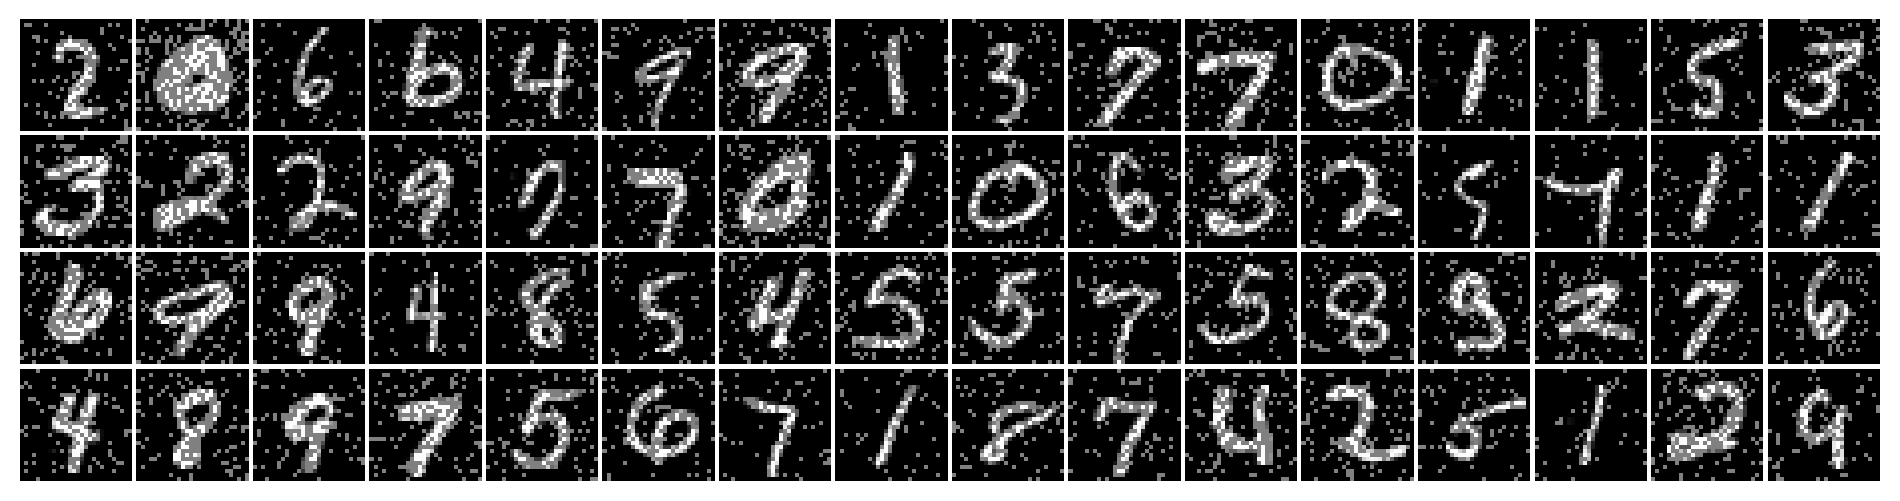

In [17]:
data_samples, mask_samples, _ = next(iter(data_loader))
fig, ax = plt.subplots(figsize=(12, 3))
plot_grid(ax, mask_data(data_samples, mask_samples.float(), .5),
          nrow=4, ncol=16)

In [18]:
imputer = Imputer().to(device)
checkpoint = torch.load(model_dir + 'imputer_epoch-{}.pth'.format(epoch_number))
imputer.load_state_dict(checkpoint['model_state_dict'])

#imputer.cuda()

<All keys matched successfully>

In [20]:
from numpy.random import random
import scipy
from scipy import linalg
from numpy import iscomplexobj
from numpy import trace
# calculate frechet inception distance
def calculate_fid(act1, act2):
# calculate mean and covariance statistics
    mu1, sigma1 = np.array(act1.mean(axis=0)), np.cov(act1, rowvar=False)
    mu2, sigma2 = np.array(act2.mean(axis=0)), np.cov(act2, rowvar=False)
    # calculate sum squared difference between mean
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = scipy.linalg.sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [21]:
fid = []
for real_data, real_mask, index in data_loader:
    with torch.no_grad():
        imputer.eval()
        impu_noise = torch.empty(batch_size, 1, 28, 28, device=device)
        impu_noise.uniform_()
        real_data = real_data.to(device)
        real_mask = real_mask.to(device).float()
        imputer = imputer.to(device)
        imputed_data = imputer(real_data, real_mask, impu_noise)
        for i in range(len(real_data)):
            fid.append(calculate_fid(real_data[i].cpu().reshape(28,28), imputed_data[i].cpu().reshape(28,28)))
        
        bbox=None
fid_array = np.array(fid)[~np.isnan(np.array(fid))]
np.mean(fid_array)

Failed to find a square root.
Failed to find a square root.
Failed to find a square root.


0.11772181299828123

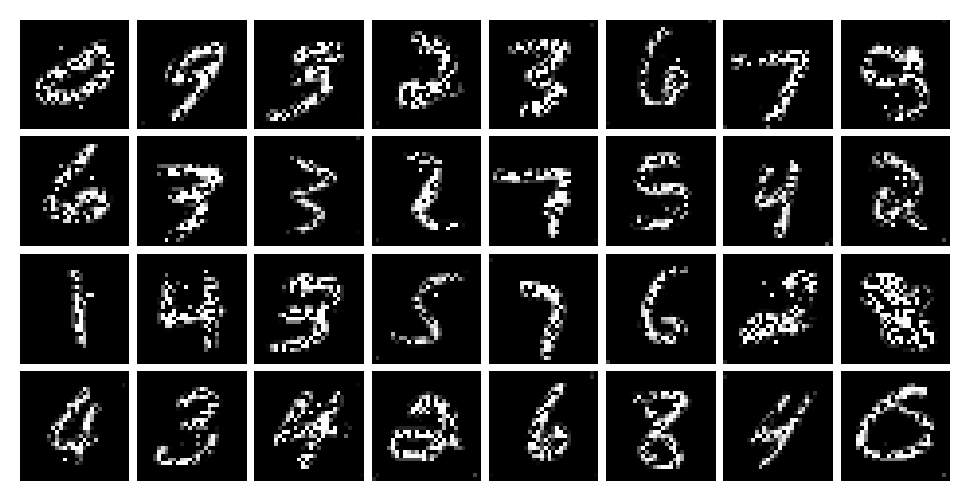

In [22]:
bbox=None
fig, ax = plt.subplots(figsize=(6, 3))
plot_grid(ax, imputed_data, bbox, gap=2)

In [24]:
import pickle as p
# To open result dict use the following code:
with open("fid_dict.p", "rb") as f:
    fid_dict = p.load(f)

fid_dict

#Maak boxplots per missingness type dus hoe goed die imputer heeft gwerkt.

{'MNAR_bernoulli_0.15': array([0.12343557, 0.11345169, 0.05283443, ..., 0.15649357, 0.05844793,
        0.06329242])}